Buffer gas sources of molecules are a big pain and understanding what makes them work well usually requires a trial and error approach. The most useful diagnostic one has is recording the time of flight profiles- probing the produced molecular beam some distance away from the source. To probe the beam we use laser light resonant with an electronic transition in the molecule, so that when a molecule passes through the laser beam it scatters photons, which are then detected with a photo-multiplier tube. The molecules in a beam have a distribution of velocities thus there is a spread of arrival times at the detection region. The recorded arrival times- the time of flight profile (ToF) is related to the distribution of velocities.

What we are mostly interested in, is the production of enough slow molecules so that we can capture them in a magneto-optical trap (MOT). The MOT for molecules is in itself a complicated beast, which requires near perfect experimental hardware settings to implement. For this reason, on a miserable day when the MOT would not work it is useful to have an indpendent diagnostic of the molecular source performance. This is the ToF.

What I tried to do here is to relate the ToF profiles with the number of molecules captured into an optimized MOT. First, I look at how the recorded signal in the ToF at different times correlates with the number of molecules capatured into the MOT. This simple tool already gives useful results. I also try to use a 1D convolutional neural network to make predictions on how many mlecules we expect to see in the MOT, based on the recorded ToF profile. This does feels like overkill, and indeed gives similar results as the more simple linear regression model.

In [114]:
import numpy as np
import glob
import zipfile
import re
from datetime import datetime
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.base import BaseEstimator, TransformerMixin

In [115]:
plt.rcParams['axes.linewidth'] = 2.0
font = {'family' : 'DejaVu Sans',
       'weight' : 'normal',
       'size' : 16.0}
plt.rc('font',**font)

In [116]:
#Utility functions to upload and prepare data:
def get_images(file_name):
    
    '''Get images of the molecular cloud from zipped files. Takes in the file name and
       outputs all images contained within the file as a numpy array.'''
    
    archive = zipfile.ZipFile(file_name + '.zip')
    archive_n = archive.namelist()
    im_names = [im for im in archive_n if ('Image' in im)]
    naturals = lambda names : [i[i.find("_")+1:i.find(".")] for i in names]
    im_names = sorted(im_names, key=naturals)
    images = np.array([io.imread(archive.open(name)) for name in im_names])
    archive.close()
    return images

def get_mol_n(images, bg, eta):
    bg_count = bg.mean(axis=1).sum()
    return ((images.sum(axis=(1,2)) - bg_count) * eta).round(0)

def get_ToFs(file_name):
        
    '''Get time of flight profiles from zipped files. Takes in the file name and
       outputs all images contained within the file as a numpy array.'''
    
    archive = zipfile.ZipFile(file_name + '.zip')
    archive_n = archive.namelist()
    tof_names = [tof for tof in archive_n if ('Tof' in tof)]
    naturals = lambda date: datetime.strptime(date[4:-4], "%Y-%m-%d--%H-%M-%S-%f")
    tof_names = sorted(tof_names, key=naturals)
    tofs = np.array([pd.read_csv(archive.open(name)) for name in tof_names])[:, :, 0]
    archive.close()
    return tofs

def build_data_set(date, file_numbers, bg_number):
    
    '''Makes the complete data set. The features are the time of flight profiles and the target values are 
       the integrated images of molecular MOT's. Outputs a pair of numpy arrays. First one contains the time of flight
       profiles, the second contains the corresponding integrated MOT images.'''
    
    eta = 1e-2
    date = '24Nov21'
    bg_file = 'CaF' + date + '00_' + format(bg_number, '03')
    n_mols = np.array([])
    tofs = np.array([])
    for f in file_numbers:
        file_number = format(f, '03')
        file = 'CaF' + date + '00_' + file_number
        im = get_images(file)
        bg = get_images(bg_file)
        mol_n = get_mol_n(im, bg, eta)
        tof = get_ToFs(file)
        tof_bg = get_ToFs(bg_file)
        tof = tof - tof_bg.mean(axis=0)
        tof = (tof * 1e3).round(4)
        
        n_mols = np.append(n_mols, mol_n)
        tofs = np.vstack((tofs, tof)) if tofs.size else tof
        
    return tofs, n_mols   

In [117]:
class BinData(BaseEstimator, TransformerMixin):
    
    '''Class for bining the recorded time of flight profiles. Useful to decrease noise in each ToF or to reduce the 
       data size.'''
    
    def __init__(self, bin_size = 50, drop_features = False, n_first = 0, n_last = 1):
        self.bin_size = bin_size
        self.drop_features = drop_features
        self.n_first = n_first
        self.n_last = n_last
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        n_samples, t_samples = X.shape[0], X.shape[1]
        n_bins = t_samples // self.bin_size 
        X_bined = X.reshape(n_samples, n_bins, self.bin_size).mean(axis=2)
        if self.drop_features:
            X_bined = self.select_features(X_bined)
            return X_bined
        else:
            return X_bined
    def select_features(self, X):
        return X[:, self.n_first : self.n_last]

# Correlation analysis and linear regression

The data set is composed of time of flight profiles (ToF) and the number of molecules captured into the MOT corresponding to each ToF. Each ToF is recorded over a time window of 12 ms and consists of 1000 points. There are 2500 ToF's in total.

In [118]:
#Load data:
X, Y = build_data_set('24Nov21', [59, 60, 61, 63, 281], 62)
MOT_number = Y * 1e-4

Text(0, 0.5, 'Signal (mV)')

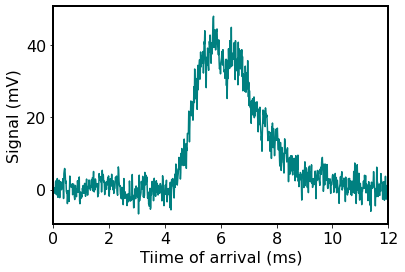

In [119]:
#Sample ToF:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.arange(1000) / 80, X[190], color='teal')
ax.set_xlim([0, 12])
ax.set_xlabel('Tiime of arrival (ms)')
ax.set_ylabel('Signal (mV)')

First, lets check how the signal in the ToF's at different times correlates with the MOT number. To this end, lets bin the ToF's into 20 bins. That is, place the 1000 voltage readings contained in each ToF into 20 bins and take their average.

In [120]:
#Split data into training, validation and test sets:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, MOT_number.reshape(-1, 1))
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [121]:
pipe_multi = Pipeline([
    ('bin_and_select', BinData(bin_size = 50, drop_features = True, n_first = 0, n_last = 21)),
    ('standard_scaler', StandardScaler())
])

In [122]:
X_train_multi_feature = pipe_multi.fit_transform(X_train)
X_test_multi_feature = pipe_multi.transform(X_test)

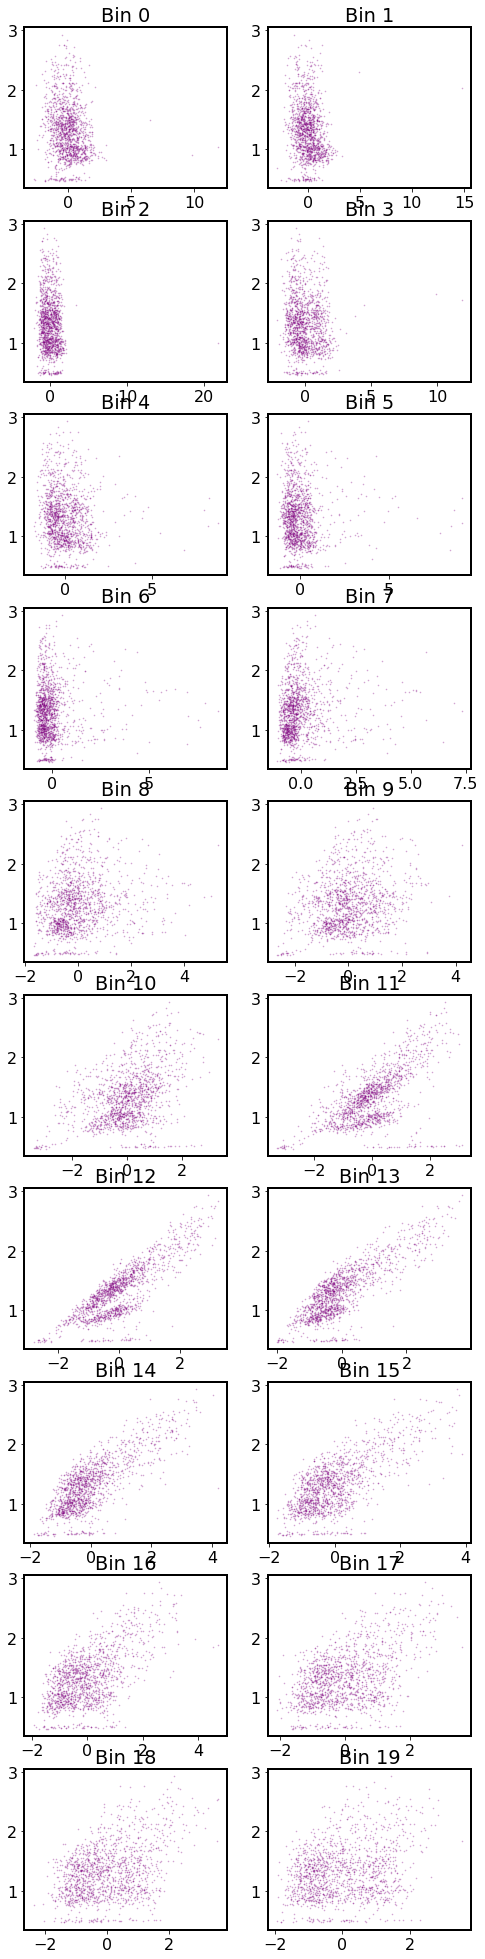

In [123]:
fig, ax = plt.subplots(10, 2, figsize=(8,35))

for i, j in zip(ax.flatten(), range(20)):
    i.scatter(X_train_multi_feature[:, j], y_train, color='purple', alpha=0.3, s=0.4)
    i.set_title('Bin {0}'.format(j))

Text(0, 0.5, 'Signal (mV)')

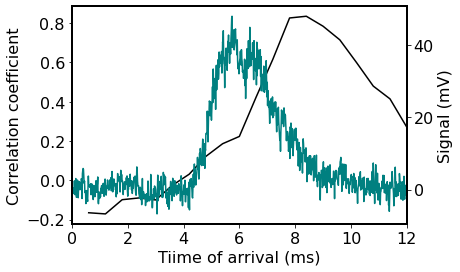

In [124]:
data_matrix = np.column_stack((X_train_multi_feature, y_train))
cc = np.corrcoef(data_matrix, rowvar=False)[-1, :20]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.arange(12 / 20, 12 + 12 / 20, 12 / 20), cc, color='black')
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('Tiime of arrival (ms)')
ax2=ax.twinx()
ax2.plot(np.arange(1000) / 80, X[190], color='teal')
ax2.set_xlim([0, 12])
ax2.set_xlabel('Tiime of arrival (ms)')
ax2.set_ylabel('Signal (mV)')

Looks like the MOT number has the highest correlation with bin 12. Lets try to make predictions using a linear regression model with the signal in bin 12 as the feature.

In [125]:
pipe_single = Pipeline([
    ('bin_and_select', BinData(bin_size = 50, drop_features = True, n_first = 12, n_last = 13)),
    ('standard_scaler', StandardScaler())
])

In [126]:
X_train_single_feature = pipe_single.fit_transform(X_train)
X_test_single_feature = pipe_single.transform(X_test)

In [127]:
reg_model = LinearRegression()
reg = reg_model.fit(X_train_single_feature, y_train)
predictions_reg = reg.predict(X_test_single_feature)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.05322781127183441


This is pretty decent already. Now we can include the rest of the bins as features in the linear regression model and see whether the predicting performance could be improved any further.

In [128]:
reg_model = LinearRegression()
reg = reg_model.fit(X_train_multi_feature, y_train)
predictions_reg = reg.predict(X_test_multi_feature)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.052419754967703625


Text(0, 0.5, 'Measured ($10^{4}$)')

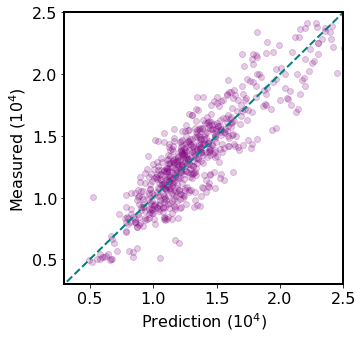

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

Even better! Lets use all 1000 samples from each of the ToF's.

In [130]:
pipe_all = Pipeline([
    ('bin_and_select', BinData(bin_size = 1)),
    ('standard_scaler', StandardScaler())
])

In [131]:
X_train_all_features = pipe_all.fit_transform(X_train)
X_test_all_features = pipe_all.transform(X_test)

In [132]:
reg_model = LinearRegression()
reg = reg_model.fit(X_train_all_features, y_train)
predictions_reg = reg.predict(X_test_all_features)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.15913613379778704


Text(0, 0.5, 'Measured ($10^{4}$)')

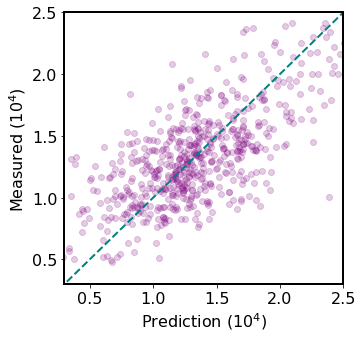

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

As might of expected this is not as good because removing the averaging associated to bining the data, introduces more variance in each of the features. Lets try some regularization techniques to mitigate this problem. Begin with ridge regression.

In [134]:
reg_model = linear_model.Ridge(alpha=1000)
reg = reg_model.fit(X_train, y_train)
predictions_reg = reg.predict(X_test)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.05612830611354173


Text(0, 0.5, 'Measured ($10^{4}$)')

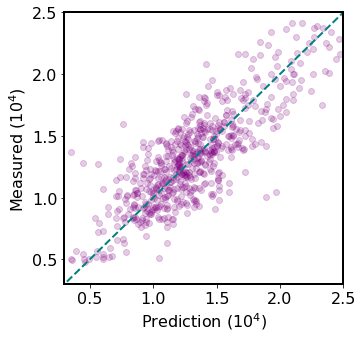

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

In [136]:
# Tune up the regularization strength in Ridge regression.
param = {
    'alpha':[10 ** (i) for i in range(-10,10)]
}
reg_model = linear_model.Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(reg_model, param, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
reg = search.fit(X_train_all_features, y_train)
reg.best_score_

-0.03665812155280889

In [137]:
reg.best_params_

{'alpha': 1000}

In [138]:
# Do the same thing for lasso regression:
reg_model = linear_model.Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(reg_model, param, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
reg = search.fit(X_train_all_features, y_train)
reg.best_score_

-0.041009951625973796

In [139]:
reg.best_params_

{'alpha': 0.01}

Ridge regression seems to be giving slighlty better results in prediction than Lasso. Optimal alpha=1000.

In [140]:
ridge_model = linear_model.Ridge(alpha=1000)
reg = ridge_model.fit(X_train_all_features, y_train)
predictions_reg = reg.predict(X_test_all_features)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.03614534251367784


Text(0.5, 1.0, 'Ridge regression predictions')

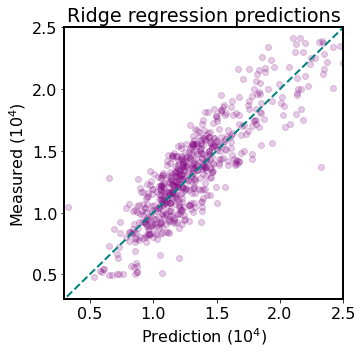

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')
ax.set_title('Ridge regression predictions')

Text(0, 0.5, 'Signal (mV)')

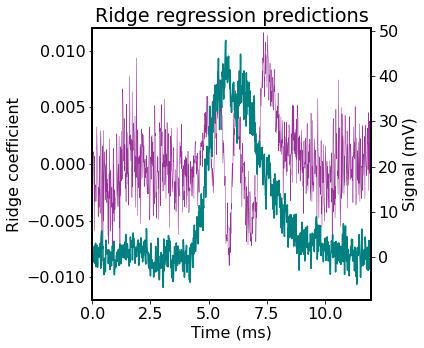

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.arange(1000) * 12 / 1000, reg.coef_.flatten(), color='purple', alpha=0.8, linewidth=0.5)
ax.set_xlim([0.0,12])
ax.set_ylim([-0.012,0.012])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Ridge coefficient')
ax.set_title('Ridge regression predictions')
ax2=ax.twinx()
ax2.plot(np.arange(1000) / 80, X[190], color='teal')
ax2.set_xlim([0, 12])
ax2.set_xlabel('Tiime of arrival (ms)')
ax2.set_ylabel('Signal (mV)')

The above graph looks strange at first sight: the peak signal has a negative correlation with number of molecules trapped in the MOT. This is a good example of multicollinearity. The signal in each time bin is correlated with the signal in the previous time bins. For this reason, the regression coefficients from multidimensional regression don't have much meaning.

Now plot the coefficients for optimal Lasso and expect the same situation.

In [143]:
ridge_model = linear_model.Lasso(alpha=0.01)
reg = ridge_model.fit(X_train_all_features, y_train)
predictions_reg = reg.predict(X_test_all_features)
mse_reg = mean_squared_error(y_test, predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.03911555735365265


Text(0, 0.5, 'Signal (mV)')

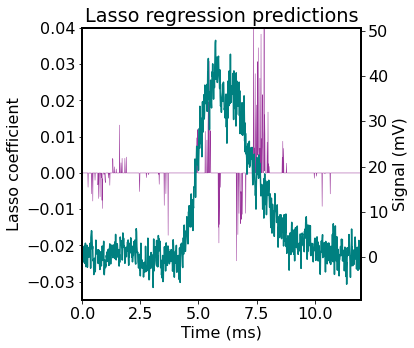

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.arange(1000) * 12 / 1000, reg.coef_.flatten(), color='purple', alpha=0.8, linewidth=0.5)
ax.set_xlim([0.0,12])
ax.set_ylim([-0.035,0.04])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Lasso coefficient')
ax.set_title('Lasso regression predictions')
ax2=ax.twinx()
ax2.plot(np.arange(1000) / 80, X[190], color='teal')
ax2.set_xlim([0, 12])
ax2.set_xlabel('Tiime of arrival (ms)')
ax2.set_ylabel('Signal (mV)')

Higher values of the coefficients corresponding to laster arival times do make sense- the more slow molecules the beam, the more are captured by the MOT. The negative coefficients around the peak position are not physical probably...

# 1D convolutional neural network

In [145]:
#Build net:
model = keras.models.Sequential([keras.layers.Conv1D(filters=8, kernel_size=5, strides=5, 
                                                     activation='relu', input_shape=(1000, 1)),
                                 keras.layers.AveragePooling1D(4),
                                 keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'),
                                 keras.layers.AveragePooling1D(8),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(32, activation='relu'),
                                 keras.layers.Dropout(0.4),
                                 keras.layers.Dense(1)
])

In [105]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 200, 8)            48        
_________________________________________________________________
average_pooling1d_14 (Averag (None, 50, 8)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 50, 16)            656       
_________________________________________________________________
average_pooling1d_15 (Averag (None, 6, 16)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                3104      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

In [106]:
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)

In [107]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, MOT_number)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [108]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_nn = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [109]:
history = model.fit(X_train_nn, y_train, epochs=100,
                   validation_data=(X_valid_nn, y_valid), verbose=0)

Text(0, 0.5, 'MSE')

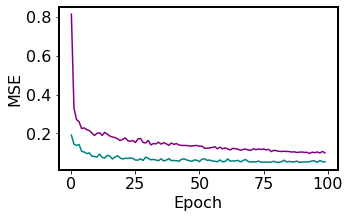

In [110]:
val_loss = np.array(history.history['val_loss'])
loss = np.array(history.history['loss'])
epochs = np.arange(0, loss.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(epochs, val_loss, color='teal')
ax.plot(epochs, loss, color='purple')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

In [111]:
predictions_nn = model.predict(X_test_nn)

Text(0, 0.5, 'Measured ($10^{4}$)')

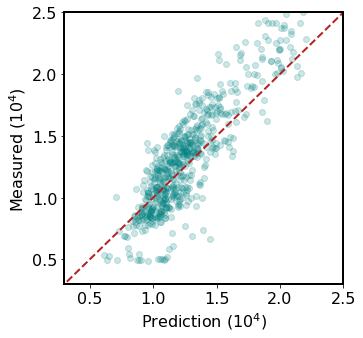

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_nn, y_test, color='teal', alpha=0.2)
ax.plot(np.arange(0.2, 2.6, 0.05), np.arange(0.2, 2.6, 0.05), color='firebrick', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3, 2.5])
ax.set_ylim([0.3, 2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

In [113]:
mse_nn = mean_squared_error(y_test, predictions_nn)
print('Test mean squared errror = ', mse_nn)

Test mean squared errror =  0.05404337869968306


# 1D convolutional neural network with trimmed data

Now I want to check whther the performance of the NN imporves when I trim the ToF's so that the times when no molecules arrive are removed (background).

In [190]:
#Build net:
model = keras.models.Sequential([keras.layers.Conv1D(filters=8, kernel_size=5, strides=5, 
                                                     activation='relu', input_shape=(500, 1)),
                                 keras.layers.AveragePooling1D(4),
                                 keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'),
                                 keras.layers.AveragePooling1D(8),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(32, activation='relu'),
                                 keras.layers.Dropout(0.4),
                                 keras.layers.Dense(1)
])

In [191]:
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)

In [192]:
X_trimmed = X[:, 300:800]
X_train_full, X_test, y_train_full, y_test = train_test_split(X_trimmed, MOT_number)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [193]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_nn = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [194]:
history = model.fit(X_train_nn, y_train, epochs=100,
                   validation_data=(X_valid_nn, y_valid), verbose=0)

Text(0, 0.5, 'MSE')

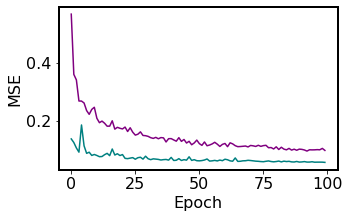

In [195]:
val_loss = np.array(history.history['val_loss'])
loss = np.array(history.history['loss'])
epochs = np.arange(0, loss.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(epochs, val_loss, color='teal')
ax.plot(epochs, loss, color='purple')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

In [196]:
predictions_nn = model.predict(X_test_nn)

Text(0, 0.5, 'Measured ($10^{4}$)')

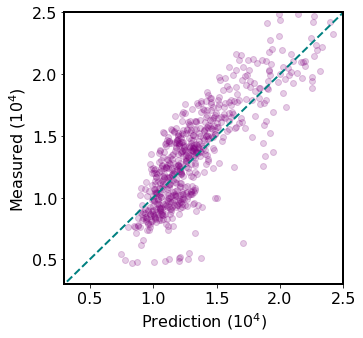

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_nn, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2, 2.6, 0.05), np.arange(0.2, 2.6, 0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3, 2.5])
ax.set_ylim([0.3, 2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

In [198]:
mse_nn = mean_squared_error(y_test, predictions_nn)
print('Test mean squared errror = ', mse_nn)

Test mean squared errror =  0.05367111690541042


Similar results...